In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [2]:
train=pd.read_csv('../data/train_balanced.csv')
test=pd.read_csv('../data/test.csv')

In [3]:
train.head(10)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,target
0,ADRAB7F3AI7OL,B0079KQEOK,Cabbott,"[0, 0]",I didn't like the arm through one part and you...,4,Simpler would be better,1397347200,"04 13, 2014",Positive
1,A8OBY4EP2OCDZ,B0002GL7ZO,Brendon,"[11, 11]",I purchased this case for my newLine 6 POD HD ...,5,A solid case for the Line 6 POD HD 500,1302220800,"04 8, 2011",Positive
2,A3177U36QW4EJB,B0002GJ6FC,LOUIS SAAD III,"[1, 1]",Sweet little neck stand. Very light weight. ...,5,Light weight. Fits in your guitar HC or gigbag,1392336000,"02 14, 2014",Positive
3,AF331KJH45RIH,B0002D0CGC,Mark Rodgers,"[0, 0]","These have been my favorite picks, for decades...",5,Dunlops,1384300800,"11 13, 2013",Positive
4,A1MH0P8PE6AT4P,B004GYOZ6G,lfeez,"[1, 1]",This is definately worth the money. I was look...,5,Absolutely awesome!,1355011200,"12 9, 2012",Positive
5,A3D42ZX96FA6EW,B0009DXEEM,Risenheart Consulting,"[0, 0]","Great little pedal, economical and worked flaw...",4,Great little pedal.,1305417600,"05 15, 2011",Positive
6,A3BMYEA3J6RBVV,B0002CZVB4,NaN,"[0, 0]",Bought it as a gift. Friend loved it very much.,5,Friend loved it very much,1405209600,"07 13, 2014",Positive
7,A2B5LSF5V85SZA,B0007GGUGA,bobby 12333,"[0, 0]",I have owned my G7th Capo over a year now & as...,5,G7th Performance Capo,1287100800,"10 15, 2010",Positive
8,A1AYYN6YUIDWVG,B000978D58,Lee,"[0, 0]","Solid, stays where I put it, and does a great ...",5,Great for the price!,1371859200,"06 22, 2013",Positive
9,A3GOS8Y7DV0E4X,B0007NQH98,Ed Figueroa,"[0, 0]",Love this little guy! I was previously using a...,5,Sounds Great!,1396828800,"04 7, 2014",Positive


## ReviewText Clean up

In [4]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer

In [5]:
stop = stopwords.words('english')
stemmer=PorterStemmer()
lemztr = WordNetLemmatizer()

### Define a function to remove stopwords, stem, and lemmatize words for reviewText.
def process_words(review, stopwords=True):
    clean=[]
#     if not isinstance(review,str):
#         return "Problem!"
    review=re.sub("[^a-zA-Z]", " ", str(review)) # letters only
    review=review.lower() # lower
    words=review.split()
    
    for word in words:
        if stopwords==True:
            if word in stop: # check for stop word
                continue
        word = stemmer.stem(word) # stemming
        word = lemztr.lemmatize(word) # lemmatize
        clean.append(word)
    return ' '.join(clean)

In [6]:
train['review_wo_stops']=train.reviewText.apply(lambda x: process_words(x))
train['review_w_stops']=train.reviewText.apply(lambda x: process_words(x, stopwords=False))
test['review_wo_stops']=test.reviewText.apply(lambda x: process_words(x))
test['review_w_stops']=test.reviewText.apply(lambda x: process_words(x, stopwords=False))

## Baseline Model: TextBlob built in sentiment analysis

In [8]:
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [9]:
def sentiment_func(X, stopwords=True):
    if stopwords==True:
        sentiment = TextBlob(X['review_wo_stops'])
    else:
        sentiment = TextBlob(X['review_w_stops'])
    X['polarity'] = sentiment.polarity
    X['subjectivity'] = sentiment.subjectivity
    return X

## Predict test labels

### Without Stopwords

In [10]:
params={1:[-0.1,0.1],2:[-0.15,-.15],3:[-0.2,0.2]}
test_wo_stops = test.apply(sentiment_func, axis=1)
test_w_stops = test.apply(lambda x: sentiment_func(x, stopwords=False), axis=1)
test_wo_stops_pred={}
test_w_stops_pred={}
for i in params:
    param=params[i]
    test_wo_stops_pred[i]=test_wo_stops.polarity.apply(lambda x: 'Negative' if x<param[0] \
                                                       else 'Positive' if x>param[1] else 'Neutral')  
    test_w_stops_pred[i]=test_w_stops.polarity.apply(lambda x: 'Negative' if x<param[0] \
                                                       else 'Positive' if x>param[1] else 'Neutral')  
for i in range(1,4):
    print(f"****** Threashold {i} *******")
    conf_mat=np.array(confusion_matrix(test_wo_stops['target'], test_wo_stops_pred[i]))
    confusion = pd.DataFrame(conf_mat, index=['negative', 'neutral', 'positive'],\
                             columns=['predicted_negative','predicted_neutral','predicted_positive'])
    print("Accuracy Score: {0:.2f}%".format(accuracy_score(test_wo_stops['target'], test_wo_stops_pred[i])*100))
    print("-"*70)
    print("Confusion Matrix\n")
    print(confusion)
    print("-"*70)
    print("Classification Report\n")
    print(classification_report(test_wo_stops['target'], test_wo_stops_pred[i]))

****** Threashold 1 *******
Accuracy Score: 72.56%
----------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_neutral  predicted_positive
negative                   7                 51                  81
neutral                   22                 56                 151
positive                  83                457                2171
----------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

    Negative       0.06      0.05      0.06       139
     Neutral       0.10      0.24      0.14       229
    Positive       0.90      0.80      0.85      2711

    accuracy                           0.73      3079
   macro avg       0.36      0.37      0.35      3079
weighted avg       0.81      0.73      0.76      3079

****** Threashold 2 *******
Accuracy Score: 86.07%
--------------------------------------------------------------

### With Stopwords

In [11]:
for i in range(1,4):
    print(f"****** Threashold {i} *******")
    conf_mat=np.array(confusion_matrix(test_w_stops['target'], test_w_stops_pred[i]))
    confusion = pd.DataFrame(conf_mat, index=['negative', 'neutral', 'positive'],\
                             columns=['predicted_negative','predicted_neutral','predicted_positive'])
    print("Accuracy Score: {0:.2f}%".format(accuracy_score(test_w_stops['target'], test_w_stops_pred[i])*100))
    print("-"*70)
    print("Confusion Matrix\n")
    print(confusion)
    print("-"*70)
    print("Classification Report\n")
    print(classification_report(test_w_stops['target'], test_w_stops_pred[i]))

****** Threashold 1 *******
Accuracy Score: 73.01%
----------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_neutral  predicted_positive
negative                  10                 52                  77
neutral                   17                 64                 148
positive                  79                458                2174
----------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

    Negative       0.09      0.07      0.08       139
     Neutral       0.11      0.28      0.16       229
    Positive       0.91      0.80      0.85      2711

    accuracy                           0.73      3079
   macro avg       0.37      0.38      0.36      3079
weighted avg       0.81      0.73      0.76      3079

****** Threashold 2 *******
Accuracy Score: 86.39%
--------------------------------------------------------------

## Try Other Classifiers

In [15]:
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


names = ["LogisticRegression","Nearest Neighbors", "RBF SVM", "Decision Tree",
         "Random Forest", "AdaBoost", "Naive Bayes", "LDA", "QDA"]
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    SVC(),
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]    

In [12]:
#### text to vector
def generate_vec(X, ngram=1, max_feature=1000): 
    cvec=CountVectorizer(lowercase=True, max_features=max_feature, analyzer='word', ngram_range=(ngram,ngram))
    X=cvec.fit_transform(X).toarray()
    return pd.DataFrame(X, columns=cvec.get_feature_names())

xtrain1g=generate_vec(train.review_w_stops)
xtest1g=generate_vec(test.review_w_stops)


score=[]
for name, clf in zip(names, classifiers):
    start = time.time()
    clf.fit(xtrain1g, train['target'])
    end=time.time()
    accuracy=clf.score(xtest1g, test['target'])
    score.append(accuracy)
    print(f"{name} model: Accuracy Score: {accuracy}. Train time: {time.time()-start} seconds")

/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression model: Accuracy Score: 0.281909710945112. Train time: 3.058044910430908 seconds
Nearest Neighbors model: Accuracy Score: 0.6375446573562845. Train time: 67.08484482765198 seconds
RBF SVM model: Accuracy Score: 0.5992205261448522. Train time: 288.90277576446533 seconds
Decision Tree model: Accuracy Score: 0.6901591425787593. Train time: 4.19825005531311 seconds
Random Forest model: Accuracy Score: 0.4913933095160766. Train time: 0.10024690628051758 seconds
AdaBoost model: Accuracy Score: 0.40759987008769083. Train time: 17.843518018722534 seconds
Naive Bayes model: Accuracy Score: 0.2455342643715492. Train time: 0.3757510185241699 seconds
LDA model: Accuracy Score: 0.15914257875933746. Train time: 3.4029080867767334 seconds


/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA model: Accuracy Score: 0.8804806755440078. Train time: 2.481031894683838 seconds


In [13]:
### Define function to generate accuracy score from different models based on different feature size

def get_score(x_train, x_test):
    score=[]
    for name, clf in zip(names, classifiers):
        start = time.time()
        clf.fit(x_train, train['target'])
        end=time.time()
        accuracy=clf.score(x_test, test['target'])
        score.append(accuracy)
        # print(f"{name} model: \n Accuracy Score: {accuracy}. Train time: {time.time()-start} seconds")
    return (time.time()-start,score)

def word2_vec(X, ngram=1, max_feature=1000):
    cvec=CountVectorizer(lowercase=True, max_features=max_feature, analyzer='word', ngram_range=(ngram,ngram))
    X=cvec.fit_transform(X).toarray()
    return pd.DataFrame(X, columns=cvec.get_feature_names())


def try_models(x_train, x_test):
    result=[]
    for size in range(1000,3001,1000):
        for ngram in range(1,4):
            print(f'Feature size: {size} N-gram: {ngram}')
            xtrain = word2_vec(x_train, ngram=ngram, max_feature=size)
            xtest = word2_vec(x_test, ngram=ngram, max_feature=size)
            time, score = get_score(xtrain, xtest)
            result.append((ngram,size,score,time))
    return result
        

In [14]:
result=try_models(train.review_w_stops,test.review_w_stops)

Feature size: 1000 N-gram: 1


/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Feature size: 1000 N-gram: 2


/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Feature size: 1000 N-gram: 3


/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Feature size: 2000 N-gram: 1


/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Feature size: 2000 N-gram: 2


/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Feature size: 2000 N-gram: 3


/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Feature size: 3000 N-gram: 1


/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Feature size: 3000 N-gram: 2


/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Feature size: 3000 N-gram: 3


/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [33]:
ngram_lst=[]
featureSize_lst=[]
score_lst=[]
time_lst=[]
for i in result:
    ngram_lst.append(i[0])
    featureSize_lst.append(i[1])
    score_lst.append(i[2])
    time_lst.append(i[3])


In [82]:
plotDF=pd.DataFrame(zip(ngram_lst,featureSize_lst,score_lst,time_lst),columns=['ngram','feature_size','score','time'])
n=len(names)
for i, model in enumerate(names):
    plotDF[model]=plotDF.score.apply(lambda x: x[i])

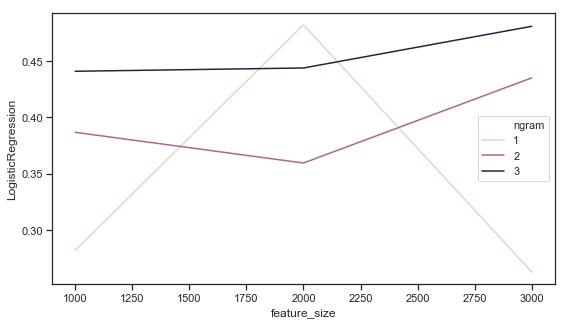

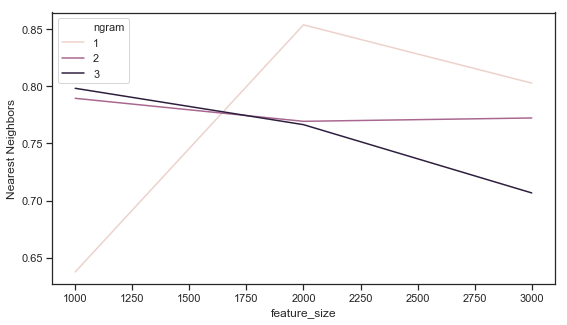

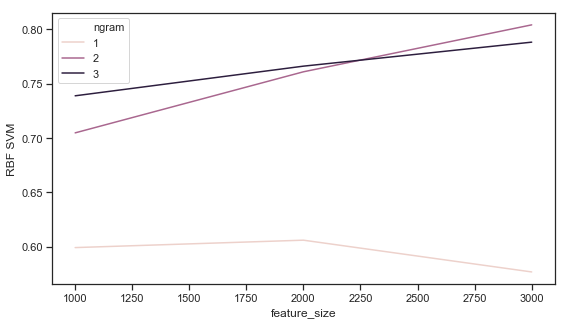

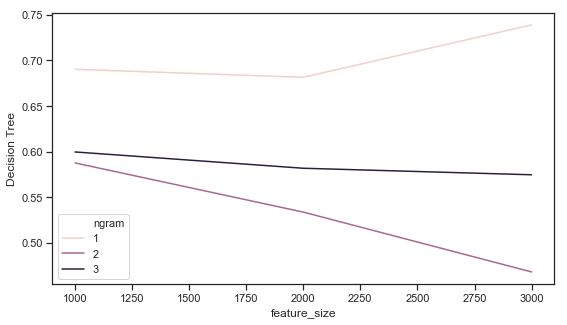

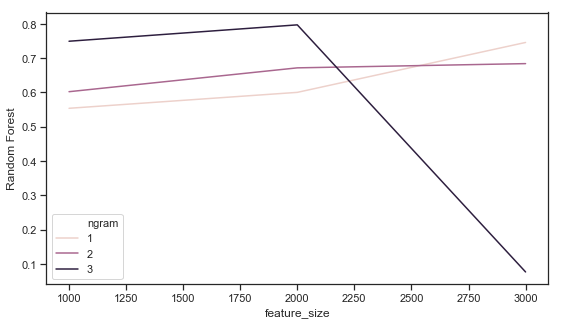

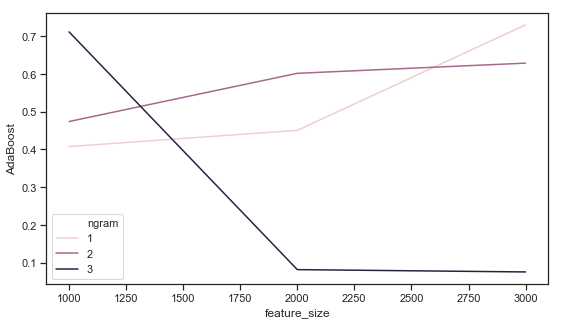

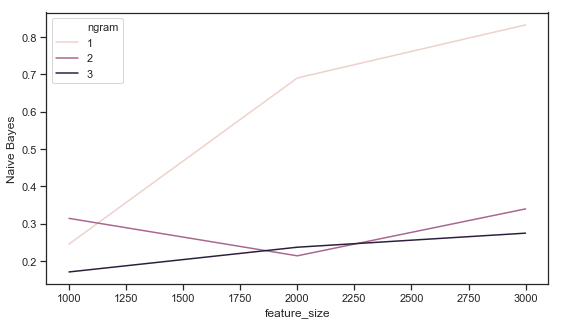

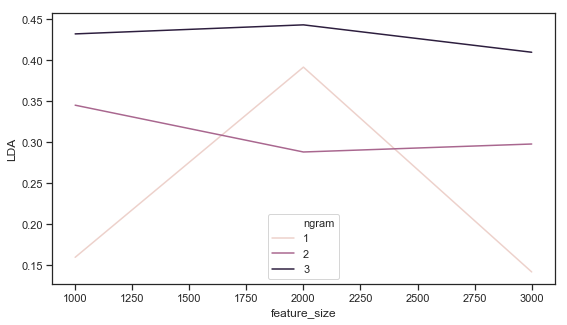

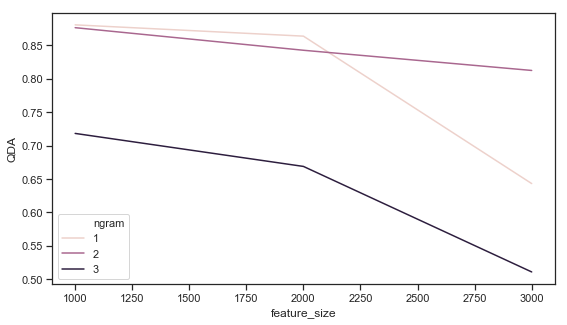

In [124]:
### import seaborn as sns
sns.set(style="ticks", color_codes=True)
for i,name in enumerate(names):
    plt.figure(figsize=(9,5))
    sns.lineplot(data=plotDF, x='feature_size', y=name, hue='ngram',legend="full")
